# Descriptive Statistics and Tests

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from pylab import rcParams

rcParams['figure.figsize'] = 20, 6
rcParams['axes.grid'] = True

In [2]:
df1 = pd.read_csv('../meta/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

df2 = pd.read_csv('../meta/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

In [3]:
from statsmodels.tsa.stattools import ccovf,ccf,periodogram
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tools.eval_measures import mse, rmse, meanabs

## Tests for Stationarity: Augmented Dickey-Fuller Test
A time series is **stationary** if the mean and variance are fixed between any two equidistant points. That is, no matter where you take your observations, the results should be the same. A times series that shows seasonality is **not** stationary.

A test for stationarity usually involves a [unit root](https://en.wikipedia.org/wiki/Unit_root_test) hypothesis test, where the null hypothesis $H_0$ is that the series is **nonstationary**, and contains a unit root. The alternate hypothesis $H_1$ supports stationarity. The augmented Dickey-Fuller Test is one such test. 

To determine whether a series is stationary we can use the [augmented Dickey-Fuller Test](https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test). In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

In [13]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string(), '\n')          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    return out

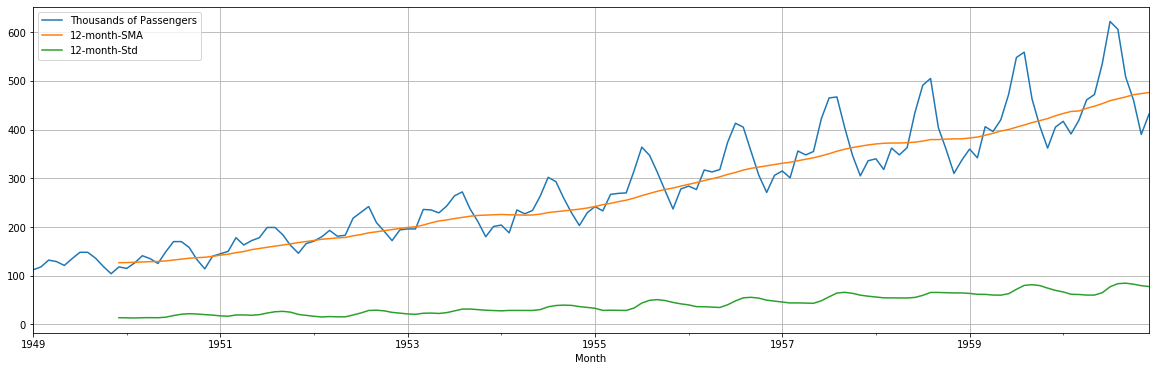

In [14]:
df1['12-month-SMA'] = df1['Thousands of Passengers'].rolling(window=12).mean()
df1['12-month-Std'] = df1['Thousands of Passengers'].rolling(window=12).std()

df1[['Thousands of Passengers','12-month-SMA','12-month-Std']].plot();

Not only is this dataset seasonal with a clear upward trend, the standard deviation increases over time as well.

In [15]:
adf_test(df1['Thousands of Passengers'], 'Airline Passengers');

Augmented Dickey-Fuller Test: Airline Passengers
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770 

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Here we have a very high p-value at 0.99, which provides weak evidence against the null hypothesis, and so we **fail to reject** the null hypothesis, and decide that our dataset is not stationary.<br>
Note: in statistics we don't "accept" a null hypothesis - nothing is ever truly proven - we just fail to reject it.

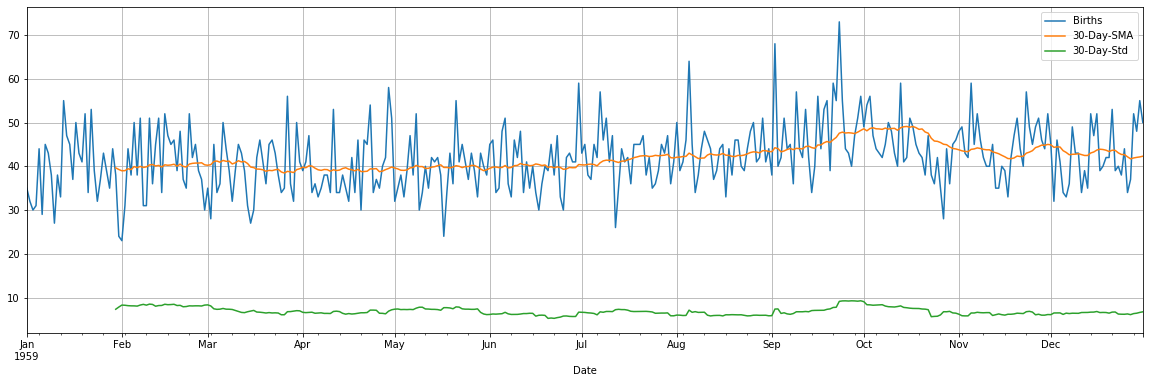

In [16]:
df2['30-Day-SMA'] = df2['Births'].rolling(window=30).mean()
df2['30-Day-Std'] = df2['Births'].rolling(window=30).std()

df2[['Births','30-Day-SMA','30-Day-Std']].plot();

In [17]:
adf_test(df2['Births'], 'Female Daily Birth');

Augmented Dickey-Fuller Test: Female Daily Birth
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089 

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In this case our p-value is very low at 0.000052, and we do reject the null hypothesis. This dataset appears to have no unit root, and is stationary.

## Evaluating forecast accuracy
Two calculations related to linear regression are <a href='https://en.wikipedia.org/wiki/Mean_squared_error'>**mean squared error**</a> (MSE) and <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'>**root mean squared error**</a> (RMSE)

The formula for the mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$MSE = {\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2$<br><br>
where $T$ is the last observation period and $l$ is the lag point up to $L$ number of test observations.

The formula for the root mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$RMSE = \sqrt{MSE} = \sqrt{{\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2}$<br><br>

The advantage of the RMSE is that it is expressed in the same units as the data.<br><br>

A method similar to the RMSE is the <a href='https://en.wikipedia.org/wiki/Mean_absolute_error'>**mean absolute error**</a> (MAE) which is the mean of the magnitudes of the error, given as<br><br>

&nbsp;&nbsp;&nbsp;&nbsp;$MAE = {\frac 1 L} \sum\limits_{l=1}^L \mid{y_{T+l}} - \hat y_{T+l}\mid$<br><br>

A forecast method that minimizes the MAE will lead to forecasts of the median, while minimizing the RMSE will lead to forecasts of the mean.

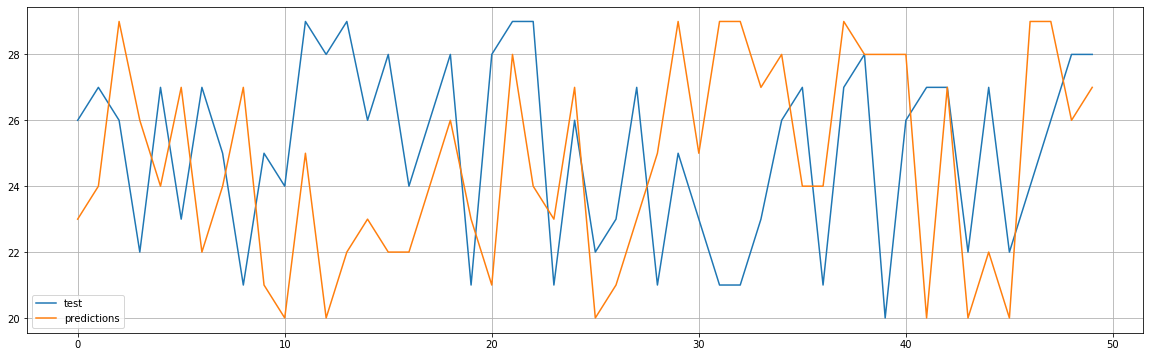

In [18]:
np.random.seed(42)
df = pd.DataFrame(np.random.randint(20,30,(50,2)),columns=['test','predictions'])
df.plot();

In [19]:
MSE = mse(df['test'],df['predictions'])
RMSE = rmse(df['test'],df['predictions'])
MAE = meanabs(df['test'],df['predictions'])

print(f'Model  MSE: {MSE:.3f}')
print(f'Model RMSE: {RMSE:.3f}')
print(f'Model  MAE: {MAE:.3f}')

Model  MSE: 17.020
Model RMSE: 4.126
Model  MAE: 3.540


## AIC / BIC
More sophisticated tests include the <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'><strong>Akaike information criterion</strong></a> (AIC) and the <a href='https://en.wikipedia.org/wiki/Bayesian_information_criterion'><strong>Bayesian information criterion</strong></a> (BIC).

The AIC evaluates a collection of models and estimates the quality of each model relative to the others. Penalties are provided for the number of parameters used in an effort to thwart overfitting. The lower the AIC and BIC, the better the model should be at forecasting.

These functions are available as

&nbsp;&nbsp;&nbsp;&nbsp;<tt>from from statsmodels.tools.eval_measures import aic, bic</tt>

but we seldom compute them alone as they are built into many of the statsmodels tools we use.

## Exposing Seasonality with Month and Quarter Plots
Statsmodels has two plotting functions that group data by month and by quarter. Note that if the data appears as months, you should employ **resampling** with an aggregate function before running a quarter plot. These plots return a `matplotlib.Figure` object.

In [23]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

In [22]:
df = pd.read_csv('../meta/airline_passengers.csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'

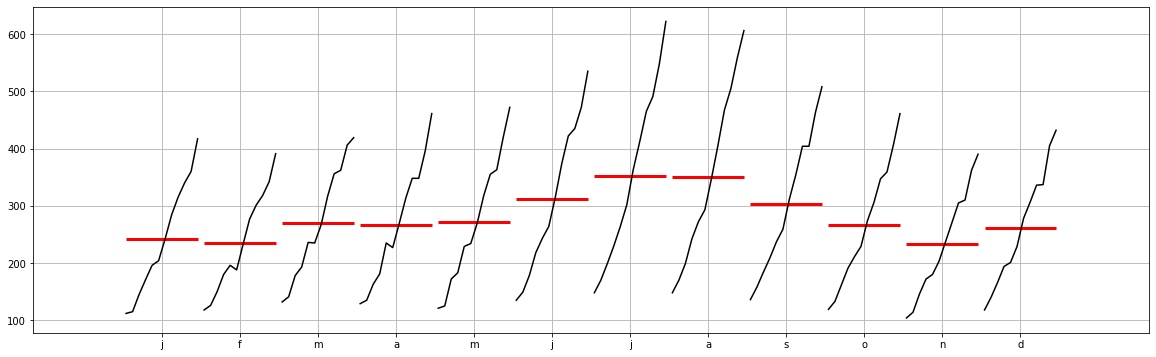

In [24]:
month_plot(df['Thousands of Passengers']);

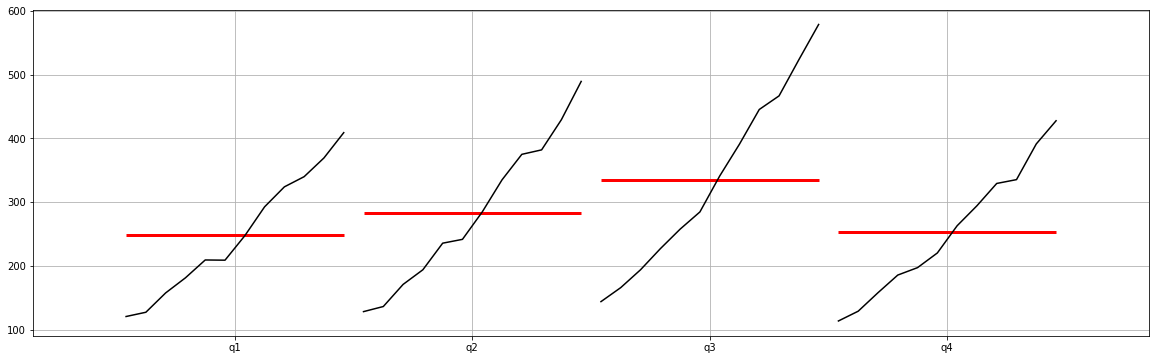

In [25]:
dfq = df['Thousands of Passengers'].resample(rule='Q').mean()
quarter_plot(dfq);